In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from joblib import dump, load
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import datetime
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer#nltk.download('wordnet') 
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#set working directory
os.chdir(r"C:\Users\mese4\Documents\The Data incubator\project\2020-08-05")

#open metadata from CORD-19 database
df = pd.read_csv('metadata.csv', encoding='ISO-8859-1')
df.head()

C:\Users\mese4\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,1.14726e+07,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,1.1668e+07,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,1.1668e+07,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,1.16869e+07,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,1.16869e+07,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [2]:
#set up time 

rule = rrulewrapper(YEARLY, byeaster=1, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')



In [3]:
#create Preprint/peer-reviewed tag
#Drop NAN from abstracts

df_source = df['source_x']
def preprint(a):

    if 'BioRxiv' in a :
        return 'Preprint'
    elif 'MedRxiv' in a:
        return 'Preprint'
    elif 'ArXiv' in a:
        return 'Preprint'
    else:
        return 'Peer-Review'
    
pre_pr = [preprint(n) for n in df_source]

df_abs = pd.DataFrame(pre_pr,columns =['preprint'])  

df['preprint'] = df_abs #Add preprint tagg to original df

df_19 = df[(df['publish_time'] > '2019-12-01')] #Cut-off date

#convert time to datatime for ploting propouses

df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce') 

df_19['year'] = df['publish_time'].dt.year #get year column
df_19['month'] = df['publish_time'].dt.month #get month column

#mont_year column

df_19 ['year_month'] = df_19['year'].map(str) + '-' + df_19['month'].map(str)

#Drop rows with abstracts = NaN/emty
df_19 = df_19.dropna(subset = ['abstract'])
df_19.head()

C:\Users\mese4\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mese4\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mese4\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,preprint,year,month,year_month
4203,p58n51xv,NaN,PMC,Characterisation of Crandell-Rees Feline Kidne...,10.1016/j.rvsc.2019.10.012,PMC6863388,3.16832e+07,cc-by-nc-nd,The Crandell-Rees Feline Kidney Cell (CRFK) is...,2019-12-05,...,NaN,NaN,NaN,document_parses/pmc_json/PMC6863388.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,Peer-Review,2019.0,12.0,2019.0-12.0
4213,heo6mtxk,d84f1c9036052ca0d9f8216cac4c5118ad8cea19,PMC,Half-Life of African Swine Fever Virus in Ship...,10.3201/eid2512.191002,PMC6874236,3.15246e+07,no-cc,African swine fever virus is transmissible thr...,2019-12-05,...,NaN,NaN,document_parses/pdf_json/d84f1c9036052ca0d9f82...,document_parses/pmc_json/PMC6874236.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,Peer-Review,2019.0,12.0,2019.0-12.0
4227,4tt0vnr4,aa3858e3cf21baa00c6f60272e4b59d3490129e0,PMC,CXCR6 regulates localization of tissue-residen...,10.1084/jem.20181308,PMC6888981,3.15586e+07,cc-by-nc-sa,Resident memory T cells (T(RM) cells) are an i...,2019-12-02,...,NaN,NaN,document_parses/pdf_json/aa3858e3cf21baa00c6f6...,document_parses/pmc_json/PMC6888981.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,Peer-Review,2019.0,12.0,2019.0-12.0
4230,9c0zrp7p,23d0641f1f78528bbf3fa7b0b749abc1299a9cb4,PMC,Local risk perception enhances epidemic control,10.1371/journal.pone.0225576,PMC6890219,3.17946e+07,cc-by,"As infectious disease outbreaks emerge, public...",2019-12-03,...,NaN,NaN,document_parses/pdf_json/23d0641f1f78528bbf3fa...,document_parses/pmc_json/PMC6890219.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,Peer-Review,2019.0,12.0,2019.0-12.0
4232,iaktm72a,9be8c80283a7fed59057d7788eb2850708f45450,PMC,Curcumin to Promote the Synthesis of Silver NP...,10.1038/s41598-019-54752-4,PMC6890765,3.17969e+07,cc-by,This work presents a simple one-pot protocol t...,2019-12-03,...,NaN,NaN,document_parses/pdf_json/9be8c80283a7fed59057d...,document_parses/pmc_json/PMC6890765.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,Peer-Review,2019.0,12.0,2019.0-12.0


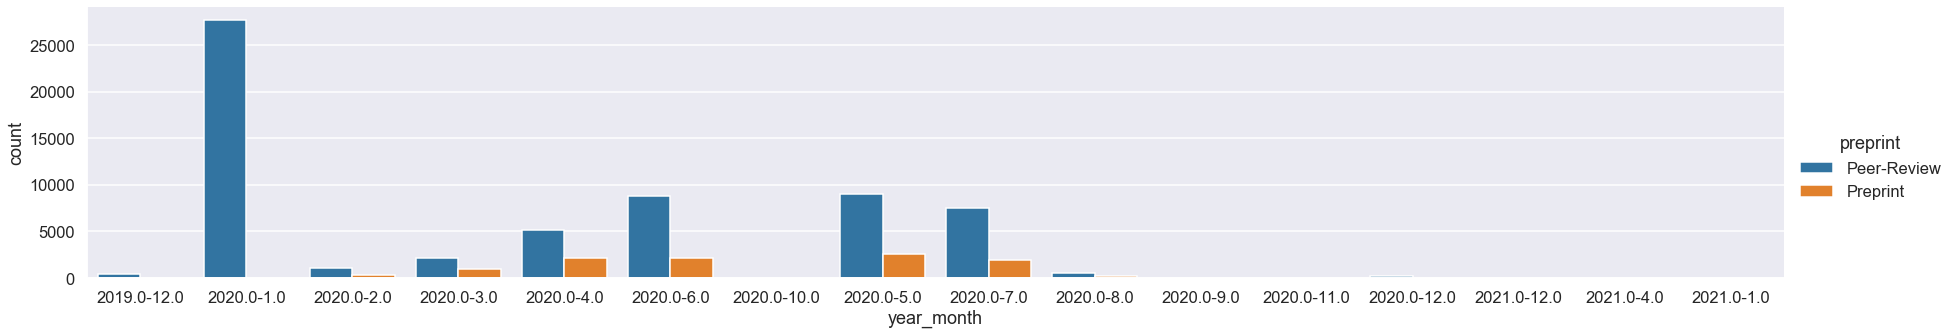

In [5]:
sns.set_context("talk")
sns.set_style('darkgrid')

g = sns.catplot(x="year_month", hue="preprint", 

                data=df_19, kind="count",

                height=5, aspect=5)



In [4]:
#Lemmanisation

dataset=df_19

##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
new_words = ["using", "show", 'covid','patient','the','we','in','disease','patients','treatment','viral','data','including','coronavirus','health','study',"result",'unknown','2555','method','infection','day','case','however','moreover','conclusion','virus','patient', "large", "also", "iv", "one",'nan', "new", "previously", "shown",'recently','promising']
stop_words = stop_words.union(new_words)

#Double check that abstracts are strings
dataset['abstract_'] = dataset['abstract'].astype(str)


corpus = []

for i in range(0, len(dataset['abstract_'])):
    
    text = dataset['abstract_'].iloc[i] 
    text = text.split() 
    
    ##Stemming
    ps = PorterStemmer()    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word.lower() in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)



In [5]:
#add corpus back to the df and drop Nan
dataset['corpus'] = corpus
dataset = dataset.dropna(subset = ['corpus'])

In [6]:
#CORD19_processed creates a lighet df to iterate over

CORD19_processed = dataset[['cord_uid','publish_time','preprint','corpus']]
CORD19_processed = CORD19_processed.reset_index()
CORD19_processed.to_csv('CORD19_processed.csv',encoding='utf-8')


In [23]:
#You can create a subset for training/optimisation
df_sub=CORD19_processed.sample(n = 100) #create a subsample for training propouses
df_sub.to_csv('df_sub.csv',encoding='utf-8')

df_sub.head()

,cord_uid,publish_time,preprint,corpus
4555,jtaz1gdp,2020-01-03,Peer-Review,Ebola infection lead severe hemorrhagic fever ...
76331,ycyzp36r,2020,Peer-Review,present outbreak containment COVID-19 early st...
114492,f07v4gdl,2020,Peer-Review,"Pirfenidone (PFD), pyridone compound, well rec..."
148132,liw1txvm,2020-10-15,Peer-Review,strategy reduce environmental impact associate...
47692,sdbird9p,2020-03-06,Peer-Review,MRI enhanced capacity understand variation bra...
